# Compact signal Representations in FrFT Domains

A compact signal representation has multipe advantages for compression, filtering, signal separation, characterizaton, etc. The FrFT can concentrate the energy of a linear chirp on just a few components, allowing maximum compactness in fractional domain. That is, if the frequency of a signal varies linearly with time, there exists at least one optimum fractional Fourier domain with the smallest signal bandwidth. An optimum domain is called compact if the signals exist only within a certain "short" range. However, the estimation of an optimum order maight become a crucial task depending on the type of signals under analisis. To establish an optimal order to achieve maximum compactness, two elements migth be consider:

1. A criterion for measuring the compactness
2. A searching strategy

Using this information we can compute the FrFT order where this chirp energy is compact. That is

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import kurtosis, moment

from dsp.signals.fm import lfmsig
from dsp.transforms.frft import frft

sns.set_style("whitegrid")

## Test signal

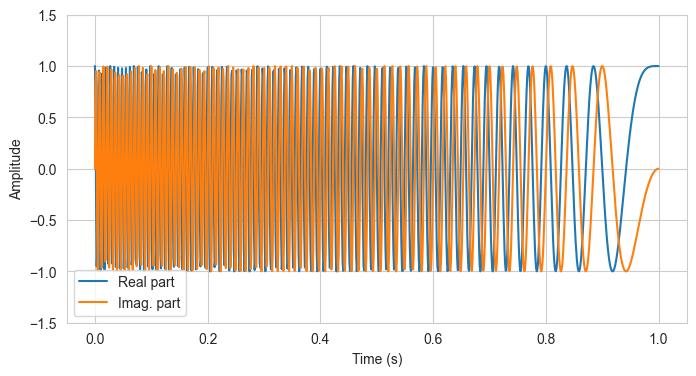

In [2]:
fs = 1000
dur = 1
t = np.linspace(0, dur, fs)

f0 = 150
f1 = 0
T = 1
x = lfmsig(t, f0=f0, f1=f1, sweep_time=1, amp=1, phi0=0)
N = len(x)

fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(t, np.real(x), label = 'Real part')
ax.plot(t, np.imag(x), label = 'Imag. part')
ax.set_ylim((-1.5, 1.5))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.legend()
plt.show()
# x = np.real(x)

### Optimum order

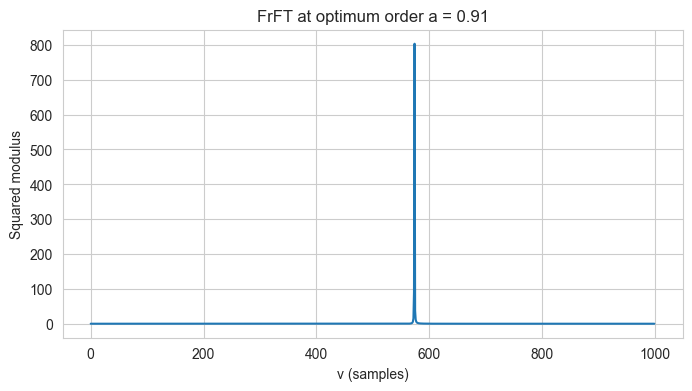

In [3]:
s = np.sqrt(N)/fs
dx = dur/s
df = (f1-f0)*s

a = (2/np.pi)*np.arctan(df/dx) + 1

xa = frft(x, a)

fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(np.abs(xa)**2)
ax.set_title(f'FrFT at optimum order a = {a:.2f}')
ax.set_xlabel('v (samples)')
ax.set_ylabel('Squared modulus')
plt.show()

## Compactness measures


### Maximum amplitude spectrum criterion

This criterion assumes that a signal has compact support in a fractional Fourier domain where the corresponding energy spectrum has large values. Therfore, the value of $|x_a(k)|$ is also maximum. The cost function of this criterion is defined as.

$$
J(a) = \max \{|x_a(k)|\}.
$$

Then, the optimal transform order is

$$
a_{\text{opt}} = \underset{a}{\mathrm{argmax}}\{J(a)\}
$$

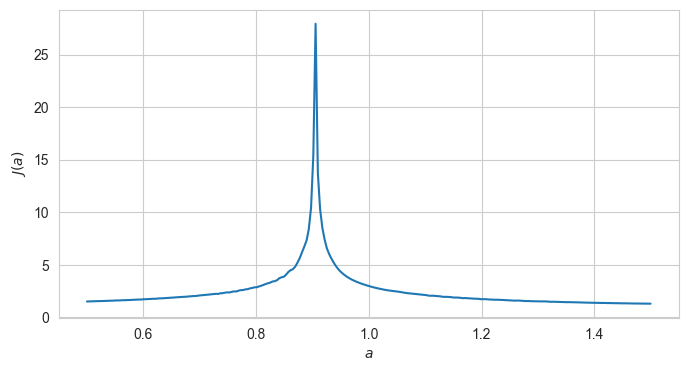

In [4]:
def maxAS(x, a):
    # Compute FrFT of signal
    xa = frft(x, a)
    # Maximum amplitude in FrFT domain
    J = np.max(np.abs(xa))
    return J

# Compute cost function for a range of a values
a_vals = np.linspace(0.5, 1.5, 250)
J = np.array([maxAS(x, a) for a in a_vals])

fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(a_vals, J)
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$J(a)$')
plt.show()

## Minimum spectral entropy criterion

The spectral entropy (SE) of a signal is a measure of its spectral power distribution. The concept is based on the Shannon entropy, or information entropy, in information theory. The SE treats the signal's normalized power distribution in the frequency domain as a probability distribution, and calculates the Shannon entropy of it. The Shannon entropy in this context is the spectral entropy of the signal.

For a signal $x(n)$, the power spectrum is $S_a(k) = |x_a(k)|^2$, where $x_a(k)$ is the discrete fractional Fourier transform of $x(n)$. The probability distribution $P_a(k)$ is then:

$$
P_a(k) = \frac{S_a(k)}{\sum_{i = 1}^N S_a(i)}
$$

where $N$ is the total fractional frequency bins. The spectral entropy $H$ follows as

$$
H(a) = - \sum_{k = 1}^N P_a(k) \log_2{P_a(k)}
$$

Normalizing:

$$
H_n(a) = - \frac{\sum_{k = 1}^N P_a(k) \log_2{P_a(k)}}{\log_2{N}}
$$

The denominator, $\log_2{N}$ represents the maximal spectral entropy of white noise, uniformly distributed in the frequency domain.

Then we can define the cost function of this criterion as

$$
J(a) = H_n(a).
$$

Then, the optimal transform order is

$$
a_{\text{opt}} = \underset{a}{\mathrm{argmin}}\{J(a)\}
$$

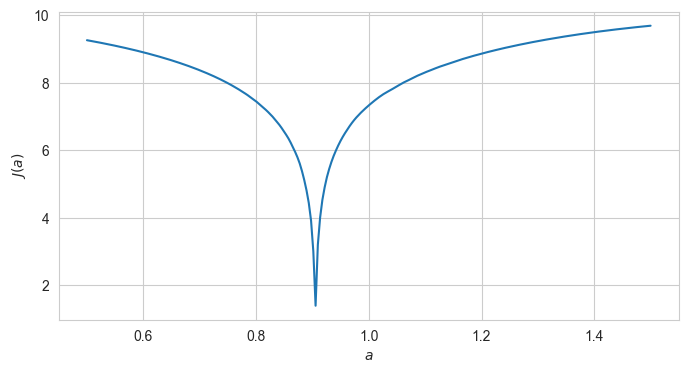

In [5]:
def minSEn(x, a):
    # Compute FrFT of signal
    xa = frft(x, a)
    # Power spectrum
    S = np.abs(xa)**2
    # Normalize to get probability distribution
    P = S/np.sum(S)
    # Avoid log(0) by masking zeros
    P = np.where(P == 0, 1e-12, P)
    # Compute Shannon entropy
    J = -np.sum(P*np.log2(P))
    return J

# Compute cost function for a range of a values
a_vals = np.linspace(0.5, 1.5, 250)
J = np.array([minSEn(x, a) for a in a_vals])

fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(a_vals, J)
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$J(a)$')
plt.show()

## Maximum spectral kurtosis criterion

In probability theory and statistics, kurtosis is a measure of the "tailedness" of the probability distribution of a real-valued random variable. 

For a signal $x(n)$, the power spectrum is $S_a(k) = |x_a(k)|^2$, where $x_a(k)$ is the discrete fractional Fourier transform of $x(n)$. The probability distribution $P_a(k)$ is then:

$$
P_a(k) = \frac{S_a(k)}{\sum_{i = 1}^N S_a(i)}
$$

where $N$ is the total fractional frequency bins. The kurtosis then follows

$$
K(a) = \frac{M_4(P_a(k))}{[M_2(P_a(k))]^2}
$$

where $M_4(\cdot)$ denotes fourth order central moment and $M_2(\cdot)$ denotes second order central moment. We can define the cost function of this criterion as

$$
J(a) = K(a).
$$

Then, the optimal transform order is

$$
a_{\text{opt}} = \underset{a}{\mathrm{argmax}}\{J(a)\}
$$

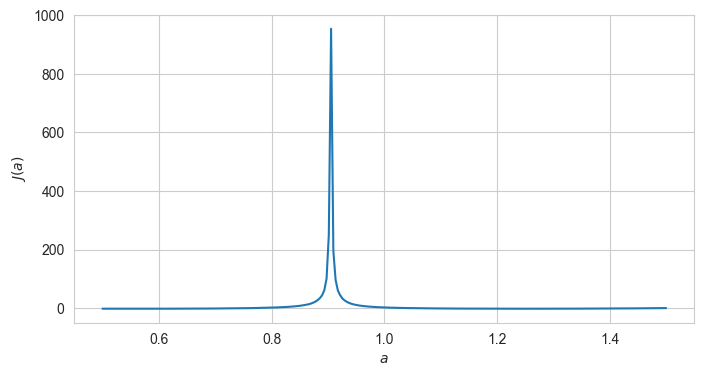

In [6]:
def maxSK(x, a):
    # Compute FrFT of signal
    xa = frft(x, a)
    # Power spectrum
    S = np.abs(xa)**2
    # Normalize to get probability distribution
    P = S / np.sum(S)
    # Add small noise if nearly constant to avoid precision loss
    if np.std(P) < 1e-8:
        P = P + np.random.normal(0, 1e-12, size=P.shape)
    # Compute kurtosis
    J = kurtosis(P)
    return J

# Compute cost function for a range of a values
a_vals = np.linspace(0.5, 1.5, 250)
J = np.array([maxSK(x, a) for a in a_vals])

fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(a_vals, J)
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$J(a)$')
plt.show()

## Minimum $\ell_1$-norm criterion

This approach consider the $\ell_1$-norm as a measure of compactness, instead of amplitude maximization. The cost function of this criterion is defined as

$$
J(a) = \|x_a(k)\|_1
$$

Then, the optimal transform order is

$$
a_{\text{opt}} = \underset{a}{\mathrm{argmin}}\{J(a)\}
$$

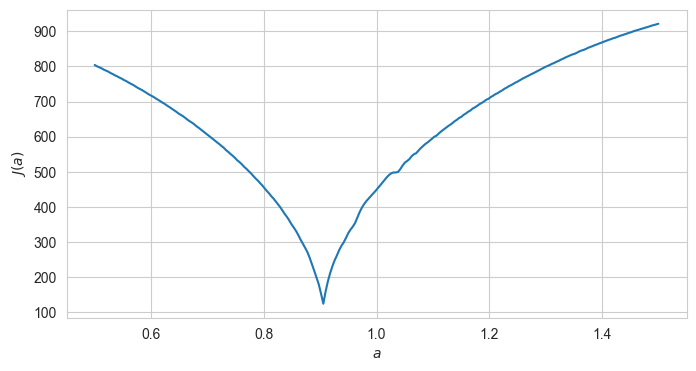

In [7]:
def minL1(x, a):
    # Compute FrFT of signal
    xa = frft(x, a)
    # Compute L1 norm (sum of absolute values)
    J = np.sum(np.abs(xa))
    return J

# Compute cost function for a range of a values
a_vals = np.linspace(0.5, 1.5, 250)
J = np.array([minL1(x, a) for a in a_vals])

fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(a_vals, J)
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$J(a)$')
plt.show()

## Maximum spectral 2nd central moment criterion

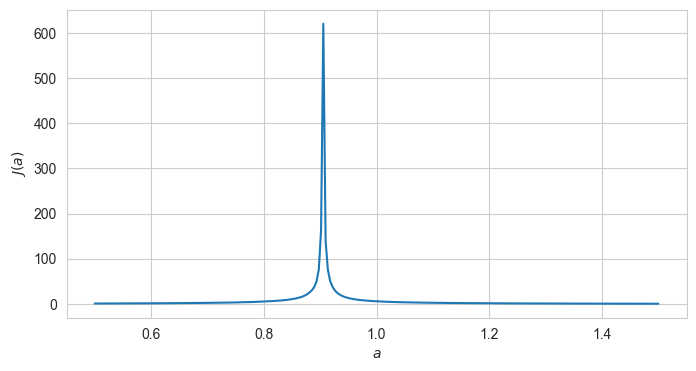

In [8]:
def max2CM(x, a):
    N = len(x)
    # Compute FrFT of signal
    xa = frft(x, a)
    # Power spectrum
    S = np.abs(xa)**2
    # Mean of power spectrum
    c = np.mean(S)
    # 2nd central moment
    J = (1/N)*np.sum((S - c)**2)
    return J

# Compute cost function for a range of a values
a_vals = np.linspace(0.5, 1.5, 250)
J = np.array([max2CM(x, a) for a in a_vals])

fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(a_vals, J)
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$J(a)$')
plt.show()

### Percent root mean square difference
This metric compares the original and transformed signals to quantify the difference, useful for assessing compactness and fidelity.

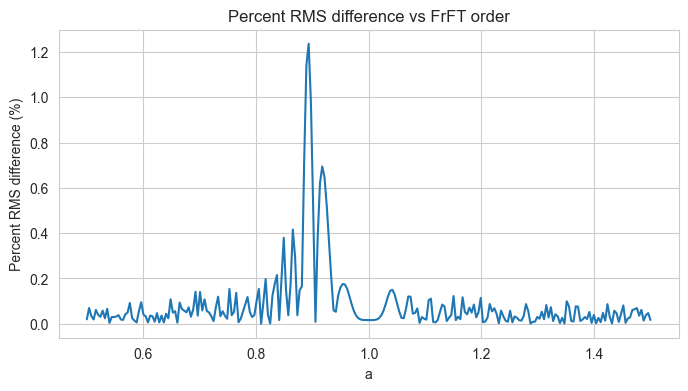

In [9]:
def percent_rms_diff(x, a):
    """
    Compute percent root mean square difference between original and FrFT domain signal.
    """
    xa = frft(x, a)
    rms_orig = np.sqrt(np.mean(np.abs(x)**2))
    rms_frft = np.sqrt(np.mean(np.abs(xa)**2))
    prmsd = 100 * np.abs(rms_orig - rms_frft) / rms_orig
    return prmsd

# Compute cost function for a range of a values
a_vals = np.linspace(0.5, 1.5, 250)
prmsd_vals = np.array([percent_rms_diff(x, a) for a in a_vals])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(a_vals, prmsd_vals)
ax.set_xlabel('a')
ax.set_ylabel('Percent RMS difference (%)')
ax.set_title('Percent RMS difference vs FrFT order')
plt.show()

### Minimum essential-bandwidth
Essential bandwidth is the smallest frequency range containing a specified percentage of the signal energy. Minimizing this in the FrFT domain helps find the most compact representation.

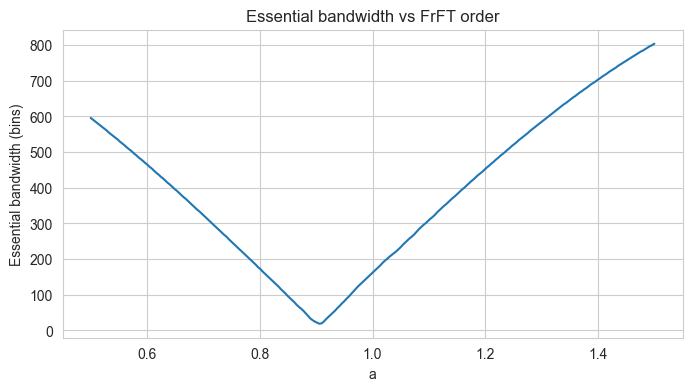

In [10]:
def min_essential_bandwidth(x, a, perc=0.99):
    """
    Compute the minimum essential bandwidth containing perc% of energy in FrFT domain.
    """
    xa = frft(x, a)
    S = np.abs(xa)**2
    total_energy = np.sum(S)
    sorted_indices = np.argsort(S)[::-1]
    cum_energy = np.cumsum(S[sorted_indices])
    idx = np.searchsorted(cum_energy, perc * total_energy)
    bandwidth = idx + 1
    return bandwidth

# Example: compute essential bandwidth for a range of a
a_vals = np.linspace(0.5, 1.5, 250)
bandwidths = np.array([min_essential_bandwidth(x, a) for a in a_vals])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(a_vals, bandwidths)
ax.set_xlabel('a')
ax.set_ylabel('Essential bandwidth (bins)')
ax.set_title('Essential bandwidth vs FrFT order')
plt.show()

### Maximum fractional time-bandwidth ratio
The time-bandwidth product in the FrFT domain quantifies the concentration of energy. Maximizing this ratio can indicate optimal compactness.

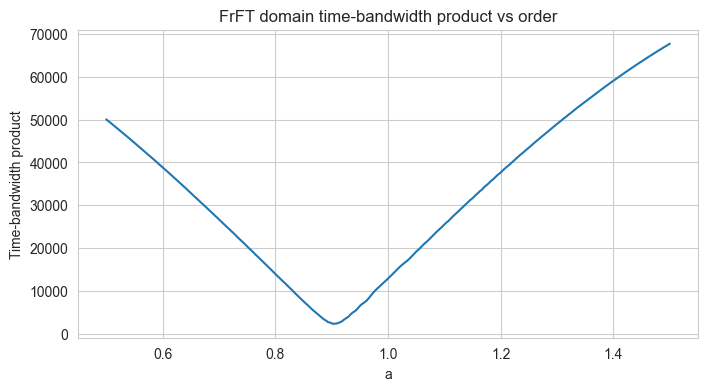

In [11]:
def max_frft_tb_ratio(x, a):
    """
    Compute the time-bandwidth product in the FrFT domain.
    """
    xa = frft(x, a)
    # Time spread (variance in time domain)
    t = np.arange(len(x))
    mean_t = np.sum(t * np.abs(x)**2) / np.sum(np.abs(x)**2)
    var_t = np.sum((t - mean_t)**2 * np.abs(x)**2) / np.sum(np.abs(x)**2)
    # Bandwidth spread (variance in FrFT domain)
    v = np.arange(len(xa))
    mean_v = np.sum(v * np.abs(xa)**2) / np.sum(np.abs(xa)**2)
    var_v = np.sum((v - mean_v)**2 * np.abs(xa)**2) / np.sum(np.abs(xa)**2)
    tb_product = np.sqrt(var_t * var_v)
    return tb_product

# Example: compute time-bandwidth product for a range of a
a_vals = np.linspace(0.5, 1.5, 250)
tb_products = np.array([max_frft_tb_ratio(x, a) for a in a_vals])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(a_vals, tb_products)
ax.set_xlabel('a')
ax.set_ylabel('Time-bandwidth product')
ax.set_title('FrFT domain time-bandwidth product vs order')
plt.show()

### FrFT moments
Moments in the fractional Fourier domain can be used to characterize the spread and compactness of a signal. The second moment (variance) is a common measure of spread.

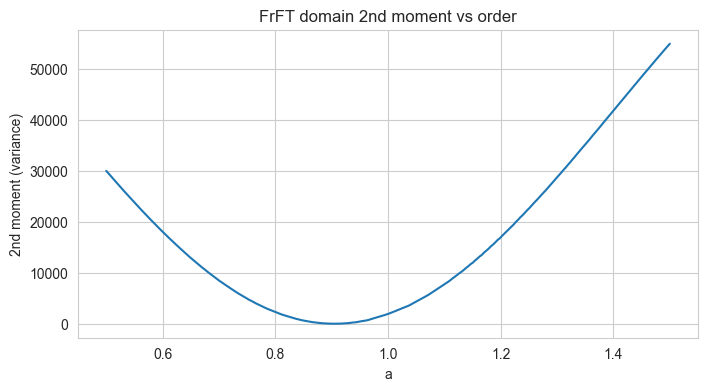

In [12]:
def frft_moment(x, a, order=2):
    """
    Compute the nth moment (default: 2nd, variance) of the FrFT domain.
    """
    xa = frft(x, a)
    v = np.arange(len(xa))
    mean = np.sum(v * np.abs(xa)**2) / np.sum(np.abs(xa)**2)
    moment = np.sum((v - mean)**order * np.abs(xa)**2) / np.sum(np.abs(xa)**2)
    return moment

# Example: compute 2nd moment for a range of a
a_vals = np.linspace(0.5, 1.5, 250)
moments = np.array([frft_moment(x, a) for a in a_vals])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(a_vals, moments)
ax.set_xlabel('a')
ax.set_ylabel('2nd moment (variance)')
ax.set_title('FrFT domain 2nd moment vs order')
plt.show()

# Searching strategies

As $a$ is continuous, the computation of $J(a)$ might be impractical for a high number of discrete values. Since the FrFT is a rotation operation on the time-frequency plane, the order range can be reduced to $[0, 1]$ for even symmetric real signals. 

### Coarse-to-fine

To further reduce the computational burden, the computation of $J(a)$ can start from a coarse level and end with a fine level. That is, at the beginning, $J(a)$ is computed at values of $a$ that are distributed sparsely over the searching interval. Then a finer searching will be done on a small interval around $a_{\text{opt}}$. This procedure is repeated until the obtained $a_{\text{opt}}$ satisfies the accuracy requirement.

The total number of required FrFTs is

$$
N_{FrFT} = \left(\frac{a_1 - a_0}{\Delta a_0} + 1\right) + \left(\frac{1}{\lambda} + 1\right) \left \lceil \frac{\log(\Delta a_0/\epsilon)}{\log(1/\lambda)} \right \rceil 
$$

In [13]:
def CtoFformax(criterion, x, a0, a1, da, lmbd, tol, iterations):
    """
    Coarse-to-fine search for the FrFT order that maximizes a given criterion.

    Parameters
    ----------
    criterion : callable
        Function that computes the compactness criterion for signal x and order a.
    x : array_like
        Input signal.
    a0 : float
        Initial lower bound for FrFT order.
    a1 : float
        Initial upper bound for FrFT order.
    da : float
        Initial step size for FrFT order.
    lmbd : float
        Step size reduction factor (0 < lmbd < 1).
    tol : float
        Tolerance for stopping criterion (minimum step size).
    iterations : int
        Maximum number of iterations.

    Returns
    -------
    aopt : float
        Estimated optimal FrFT order maximizing the criterion.
    """
    k = 1
    while k <= iterations:
        orders = np.arange(a0, a1 + da, da)
        J = np.array([criterion(x, a) for a in orders])
        aopt = orders[np.argmax(J)]
        if da <= tol:
            return aopt
        # Narrow the search interval around the current optimum
        a0 = max(a0, aopt - 0.5 * da)
        a1 = min(a1, aopt + 0.5 * da)
        da *= lmbd
        k += 1
    print('Required precision was not achieved within the number of iterations')
    return aopt

def CtoFformin(criterion, x, a0, a1, da, lmbd, tol, iterations):
    """
    Coarse-to-fine search for the FrFT order that minimizes a given criterion.

    Parameters
    ----------
    criterion : callable
        Function that computes the compactness criterion for signal x and order a.
    x : array_like
        Input signal.
    a0 : float
        Initial lower bound for FrFT order.
    a1 : float
        Initial upper bound for FrFT order.
    da : float
        Initial step size for FrFT order.
    lmbd : float
        Step size reduction factor (0 < lmbd < 1).
    tol : float
        Tolerance for stopping criterion (minimum step size).
    iterations : int
        Maximum number of iterations.

    Returns
    -------
    aopt : float
        Estimated optimal FrFT order minimizing the criterion.
    """
    k = 1
    while k <= iterations:
        orders = np.arange(a0, a1 + da, da)
        J = np.array([criterion(x, a) for a in orders])
        aopt = orders[np.argmin(J)]
        if da <= tol:
            return aopt
        # Narrow the search interval around the current optimum
        a0 = max(a0, aopt - 0.5 * da)
        a1 = min(a1, aopt + 0.5 * da)
        da *= lmbd
        k += 1
    print('Required precision was not achieved within the number of iterations')
    return aopt

#### $a_{\text{opt}}$ estimation


[CtoF] Searching for optimum FrFT order using: Maximum amplitude spectrum


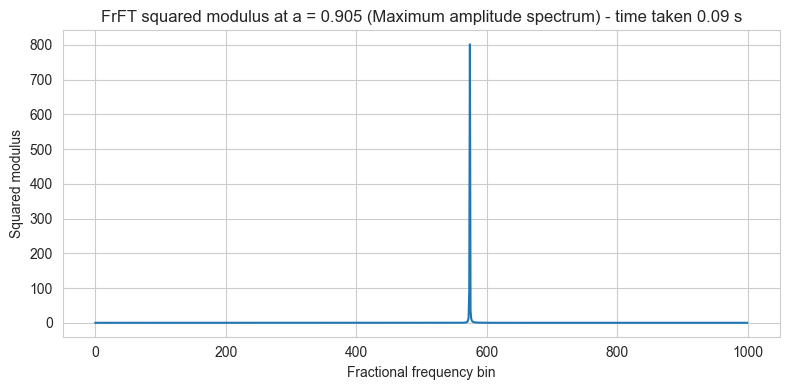


[CtoF] Searching for optimum FrFT order using: Minimum spectral entropy


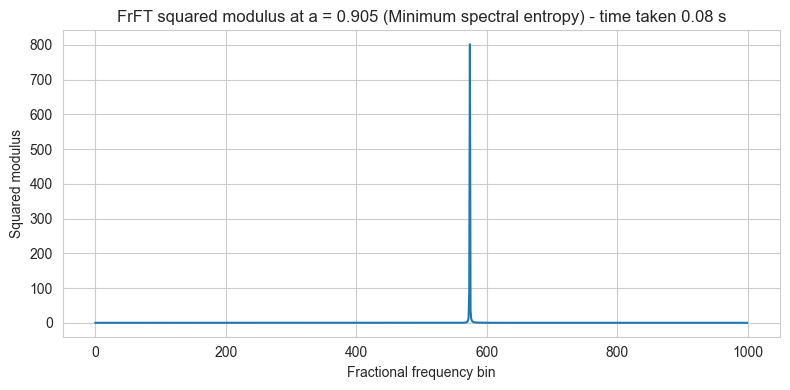


[CtoF] Searching for optimum FrFT order using: Maximum spectral kurtosis


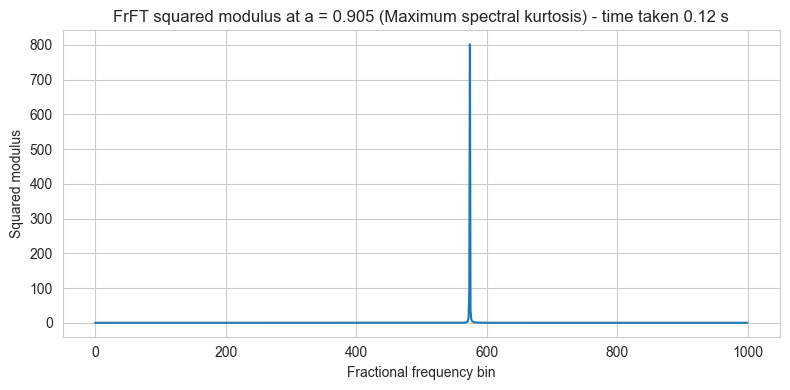


[CtoF] Searching for optimum FrFT order using: Minimum L1 norm


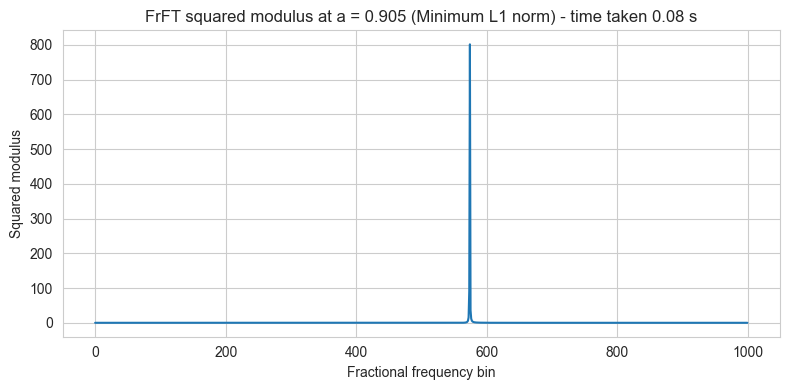


[CtoF] Searching for optimum FrFT order using: Maximum 2nd central moment


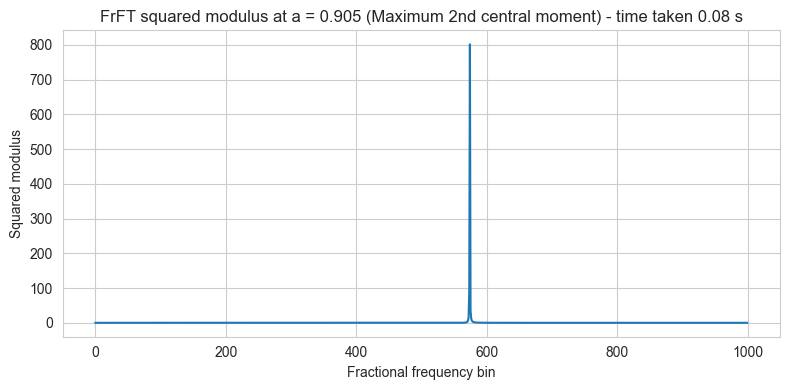

In [14]:
# Search parameters
a0 = 0          # Lower bound for FrFT order
a1 = 2          # Upper bound for FrFT order
da = 0.5        # Initial step size
tol = 1e-3      # Tolerance for stopping criterion
lmd = 0.1       # Step size reduction factor
iterations = 20 # Maximum number of iterations

criteria = [
    ("Maximum amplitude spectrum", CtoFformax, maxAS),
    ("Minimum spectral entropy", CtoFformin, minSEn),
    ("Maximum spectral kurtosis", CtoFformax, maxSK),
    ("Minimum L1 norm", CtoFformin, minL1),
    ("Maximum 2nd central moment", CtoFformax, max2CM)
]

for name, search_func, criterion_func in criteria:
    print(f"\n[CtoF] Searching for optimum FrFT order using: {name}")
    start_time = time.time()
    aopt = search_func(criterion_func, x, a0, a1, da, lmd, tol, iterations)
    end_time = time.time()

# Optionally, visualize the FrFT at the found optimum order for each criterion
    xa_opt = frft(x, aopt)
    plt.figure(figsize=(8, 4))
    plt.plot(np.abs(xa_opt)**2)
    plt.title(f'FrFT squared modulus at a = {aopt:.3f} ({name}) - time taken {end_time - start_time:.2f} s')
    plt.xlabel('Fractional frequency bin')
    plt.ylabel('Squared modulus')
    plt.tight_layout()
    plt.show()

### Genetic algorithm

In [15]:
def genetic_order_search(criterion, x, a_bounds, pop_size=30, generations=40, mutation_rate=0.1, maximize=True):
    """
    Genetic algorithm to find optimal FrFT order.
    """
    a_min, a_max = a_bounds
    # Initialize population
    population = np.random.uniform(a_min, a_max, pop_size)
    for gen in range(generations):
        # Evaluate fitness
        fitness = np.array([criterion(x, a) for a in population])
        if not maximize:
            fitness = -fitness
        # Select top individuals
        idx = np.argsort(fitness)[-pop_size//2:]
        parents = population[idx]
        # Crossover
        children = []
        while len(children) < pop_size//2:
            p1, p2 = np.random.choice(parents, 2, replace=False)
            alpha = np.random.rand()
            child = alpha * p1 + (1 - alpha) * p2
            children.append(child)
        # Mutation
        children = np.array(children)
        mutation = np.random.uniform(-0.05, 0.05, size=children.shape)
        mutate_mask = np.random.rand(*children.shape) < mutation_rate
        children[mutate_mask] += mutation[mutate_mask]
        # Clip to bounds
        children = np.clip(children, a_min, a_max)
        # New population
        population = np.concatenate([parents, children])
    # Final evaluation
    fitness = np.array([criterion(x, a) for a in population])
    if not maximize:
        fitness = -fitness
    best_idx = np.argmax(fitness)
    return population[best_idx]


[GA] Searching for optimum FrFT order using: Maximum amplitude spectrum


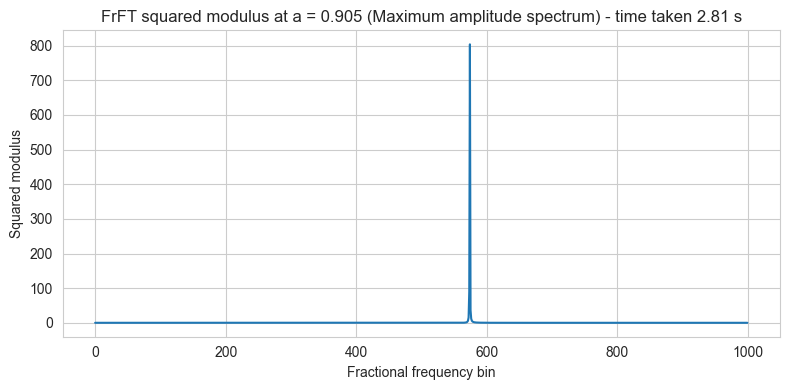


[GA] Searching for optimum FrFT order using: Minimum spectral entropy


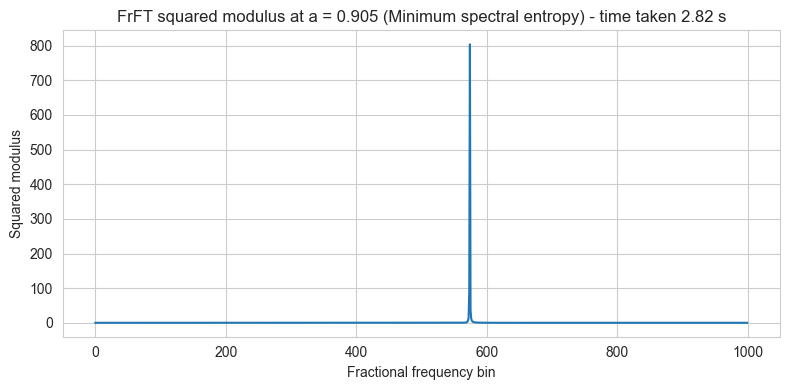


[GA] Searching for optimum FrFT order using: Maximum spectral kurtosis


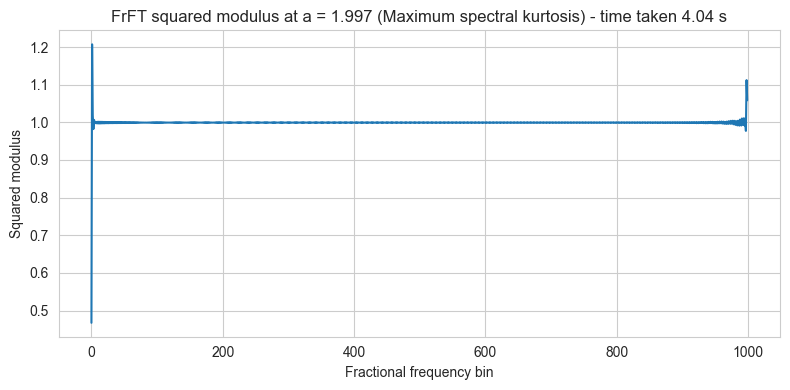


[GA] Searching for optimum FrFT order using: Minimum L1 norm


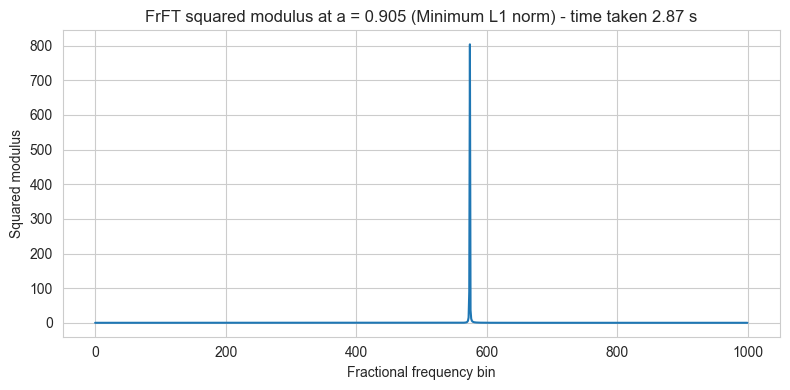


[GA] Searching for optimum FrFT order using: Maximum 2nd central moment


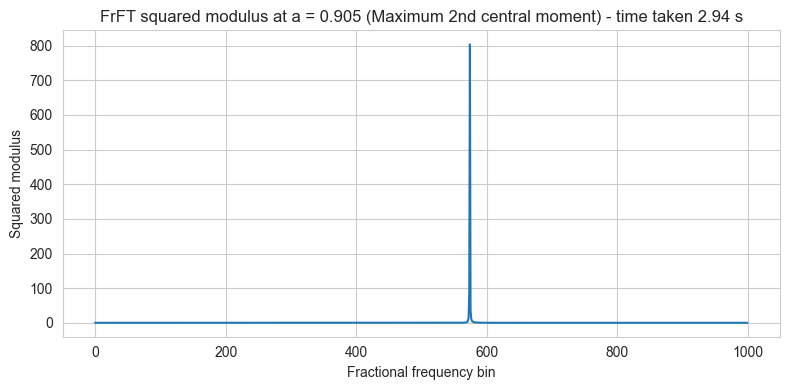

In [16]:
# Search parameters
a_bounds = (0, 2)      # Search interval for FrFT order
pop_size = 30          # Population/swarm size
generations = 40       # Number of generations/iterations
mutation_rate = 0.1    # Mutation rate for GA

criteria = [
    ("Maximum amplitude spectrum", genetic_order_search, maxAS, True),
    ("Minimum spectral entropy", genetic_order_search, minSEn, False),
    ("Maximum spectral kurtosis", genetic_order_search, maxSK, True),
    ("Minimum L1 norm", genetic_order_search, minL1, False),
    ("Maximum 2nd central moment", genetic_order_search, max2CM, True)
]

for name, search_func, criterion_func, maximize in criteria:
    print(f"\n[GA] Searching for optimum FrFT order using: {name}")
    start_time = time.time()
    aopt = search_func(criterion_func, x, a_bounds, pop_size, generations, mutation_rate, maximize)
    end_time = time.time()
    
    xa_opt = frft(x, aopt)
    plt.figure(figsize=(8, 4))
    plt.plot(np.abs(xa_opt)**2)
    plt.title(f'FrFT squared modulus at a = {aopt:.3f} ({name}) - time taken {end_time - start_time:.2f} s')
    plt.xlabel('Fractional frequency bin')
    plt.ylabel('Squared modulus')
    plt.tight_layout()
    plt.show()

### Particle Swarm optimization

In [17]:
def pso_order_search(criterion, x, a_bounds, swarm_size=30, iterations=40, w=0.7, c1=1.5, c2=1.5, maximize=True):
    """
    Particle Swarm Optimization to find optimal FrFT order.
    """
    a_min, a_max = a_bounds
    # Initialize particles
    positions = np.random.uniform(a_min, a_max, swarm_size)
    velocities = np.zeros(swarm_size)
    personal_best = positions.copy()
    personal_best_val = np.array([criterion(x, a) for a in positions])
    if not maximize:
        personal_best_val = -personal_best_val
    global_best_idx = np.argmax(personal_best_val)
    global_best = personal_best[global_best_idx]
    for i in range(iterations):
        for j in range(swarm_size):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities[j] = (w * velocities[j] +
                             c1 * r1 * (personal_best[j] - positions[j]) +
                             c2 * r2 * (global_best - positions[j]))
            positions[j] += velocities[j]
            positions[j] = np.clip(positions[j], a_min, a_max)
            val = criterion(x, positions[j])
            if not maximize:
                val = -val
            if val > personal_best_val[j]:
                personal_best[j] = positions[j]
                personal_best_val[j] = val
        global_best_idx = np.argmax(personal_best_val)
        global_best = personal_best[global_best_idx]
    return global_best


[PSO] Searching for optimum FrFT order using: Maximum amplitude spectrum


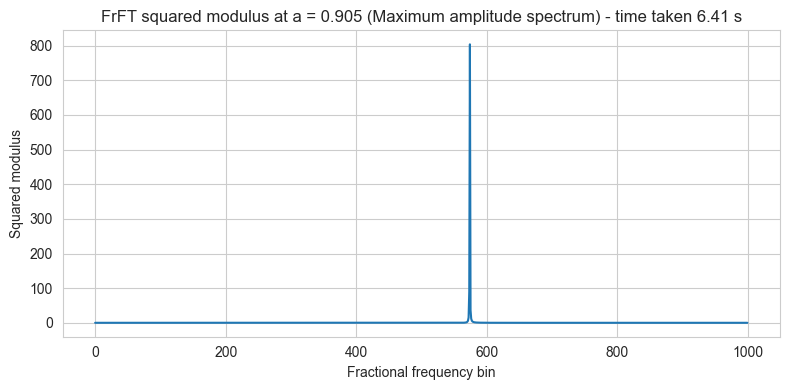


[PSO] Searching for optimum FrFT order using: Minimum spectral entropy


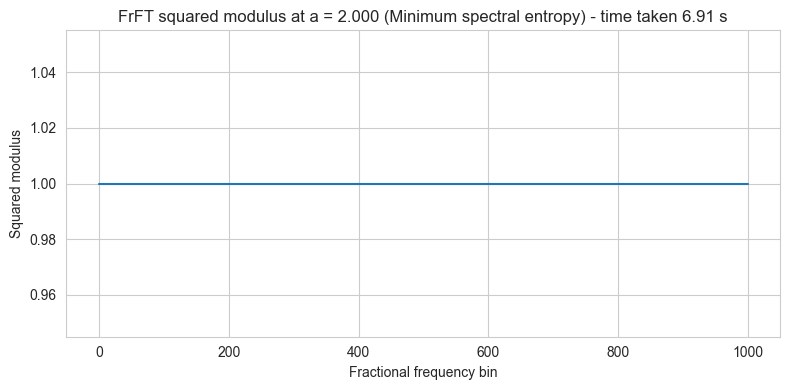


[PSO] Searching for optimum FrFT order using: Maximum spectral kurtosis


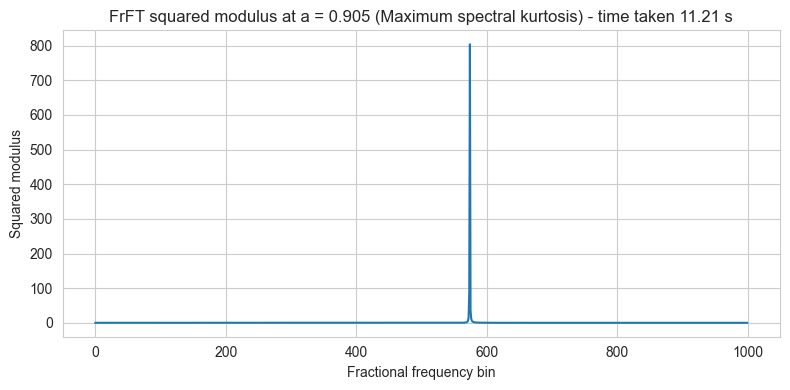


[PSO] Searching for optimum FrFT order using: Minimum L1 norm


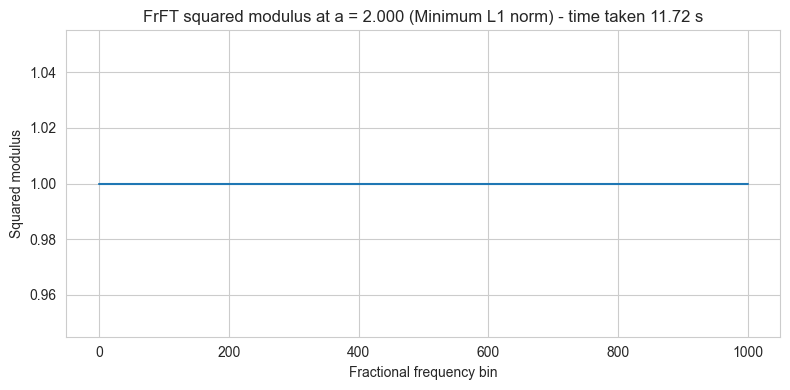


[PSO] Searching for optimum FrFT order using: Maximum 2nd central moment


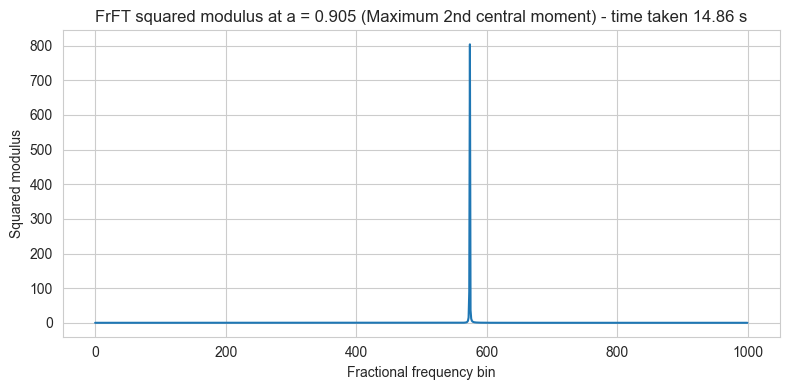

In [18]:
# Search parameters
a_bounds = (0, 2)      # Search interval for FrFT order
pop_size = 30          # Population/swarm size
generations = 40       # Number of generations/iterations
mutation_rate = 0.1    # Mutation rate for GA

criteria = [
    ("Maximum amplitude spectrum", pso_order_search, maxAS, True),
    ("Minimum spectral entropy", pso_order_search, minSEn, False),
    ("Maximum spectral kurtosis", pso_order_search, maxSK, True),
    ("Minimum L1 norm", pso_order_search, minL1, False),
    ("Maximum 2nd central moment", pso_order_search, max2CM, True)
]

for name, search_func, criterion_func, maximize in criteria:
    print(f"\n[PSO] Searching for optimum FrFT order using: {name}")
    start_time2 = time.time()
    aopt = search_func(criterion_func, x, a_bounds, pop_size, generations, mutation_rate, maximize)
    end_time = time.time()
    
    xa_opt = frft(x, aopt)
    plt.figure(figsize=(8, 4))
    plt.plot(np.abs(xa_opt)**2)
    plt.title(f'FrFT squared modulus at a = {aopt:.3f} ({name}) - time taken {end_time - start_time:.2f} s')
    plt.xlabel('Fractional frequency bin')
    plt.ylabel('Squared modulus')
    plt.tight_layout()
    plt.show()